In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
 
from matplotlib import pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoETS, AutoARIMA, Naive

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

/home/grc/arep/time_series/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### 1. Consider the PBS data which has aggregation structure ATC1/ATC2 * Concession * Type.

In [3]:
df = pd.read_csv("../data/PBS.csv", index_col=[0])

df = df[["Month", "ATC1", "ATC2", "Concession", "Type", "Scripts"]]

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

In [4]:
df.head()

,Month,ATC1,ATC2,Concession,Type,Scripts
1,1991-07-01,A,A01,Concessional,Co-payments,18228
2,1991-08-01,A,A01,Concessional,Co-payments,15327
3,1991-09-01,A,A01,Concessional,Co-payments,14775
4,1991-10-01,A,A01,Concessional,Co-payments,15380
5,1991-11-01,A,A01,Concessional,Co-payments,14371


##### a) Produce plots of the aggregated Scripts data by Concession, Type and ATC1.

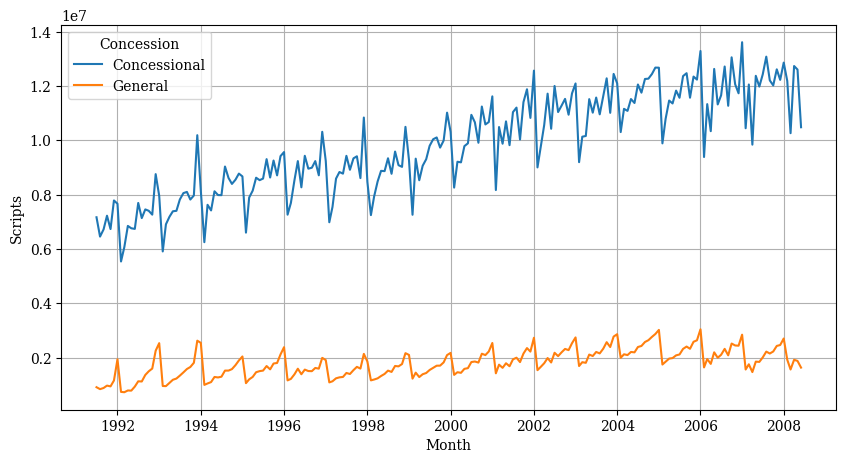

In [6]:
dfc = df[["Month", "Concession", "Scripts"]].groupby(["Month", "Concession"]).sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(dfc, x="Month", y="Scripts", hue="Concession", ax=ax)
ax.grid(2);

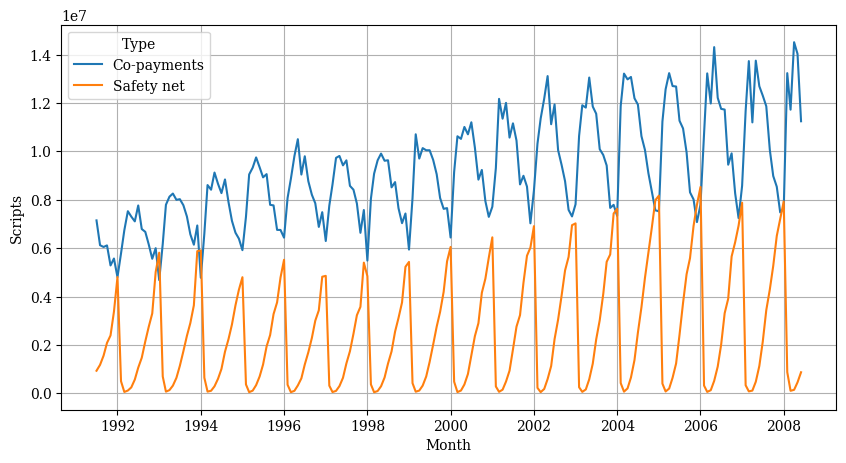

In [7]:
dfc = df[["Month", "Type", "Scripts"]].groupby(["Month", "Type"]).sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(dfc, x="Month", y="Scripts", hue="Type", ax=ax)
ax.grid(2);

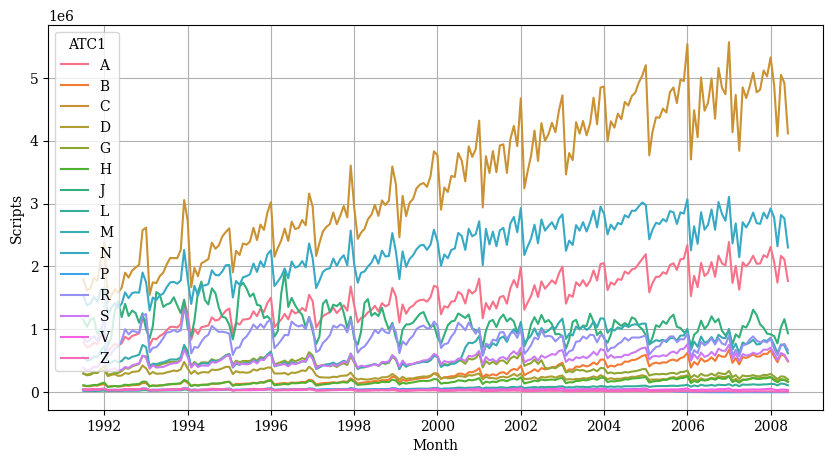

In [8]:
dfc = df[["Month", "ATC1", "Scripts"]].groupby(["Month", "ATC1"]).sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(dfc, x="Month", y="Scripts", hue="ATC1", ax=ax)
ax.grid(2);

##### b) Forecast the PBS Scripts data using ETS, ARIMA and SNAIVE models, applied to all but the last three years of data.

In [11]:
train = df[df.Month < "2006-01-01"].reset_index(drop=True)
test = df[df.Month >= "2006-01-01"].reset_index(drop=True)

train.rename(columns={"Month": "ds", "Scripts": "y"}, inplace=True)
test.rename(columns={"Month": "ds", "Scripts": "y"}, inplace=True)

In [12]:
hierarchy = [
    ['ATC1', 'ATC2'],
    ['ATC1', 'ATC2', 'Type'],
    ['ATC1', 'ATC2', 'Concession'],
    ['ATC1', 'ATC2', 'Concession', 'Type']
]

train, df_s_agg, tags = aggregate(train, hierarchy)
test, _, _ = aggregate(test, hierarchy)

In [ ]:
models = [
    AutoETS(
        season_length=12,
        alias="ets"
    ),
    AutoARIMA(
        season_length=12,
        alias="arima"
    ),
    Naive(alias="naive")
]

sf = StatsForecast(
    models=models,
    freq="MS",
    n_jobs=-1
)

sf.fit(train)

forecast = sf.forecast(h=test.ds.nunique(), fitted=True)
fitted_values = sf.forecast_fitted_values()

##### c) Reconcile each of the forecasts using MinT.

In [19]:
r = [
    MinTrace(method='ols', nonnegative=True),
    #MinTrace(method='wls_struct', nonnegative=True),
    #MinTrace(method='mint_shrink', nonnegative=True), 
]

r_model = HierarchicalReconciliation(reconcilers=r)

In [ ]:
forecast_rec = r_model.reconcile(
    tags=tags,
    S=df_s_agg,
    Y_hat_df=forecast,
    Y_df=fitted_values,
)

In [22]:
forecast_rec

,ds,ets,arima,naive,ets/MinTrace_method-ols_nonnegative-True,arima/MinTrace_method-ols_nonnegative-True,naive/MinTrace_method-ols_nonnegative-True
unique_id,,,,,,,
A/A01,2006-01-01,20228.835938,20013.505859,18198.0,2.022057e+04,2.003174e+04,18198.0
A/A01,2006-02-01,15193.364258,13885.789062,18198.0,1.484626e+04,1.448360e+04,18198.0
A/A01,2006-03-01,16768.816406,14674.327148,18198.0,1.634715e+04,1.556746e+04,18198.0
A/A01,2006-04-01,16115.964844,15413.143555,18198.0,1.583659e+04,1.630763e+04,18198.0
A/A01,2006-05-01,16286.187500,15352.031250,18198.0,1.616953e+04,1.643655e+04,18198.0
...,...,...,...,...,...,...,...
Z/Z/General/Safety net,2008-02-01,78.220924,-27.329992,787.0,0.000000e+00,0.000000e+00,787.0
Z/Z/General/Safety net,2008-03-01,11.968535,-85.030411,787.0,0.000000e+00,0.000000e+00,787.0
Z/Z/General/Safety net,2008-04-01,20.054014,-31.988489,787.0,0.000000e+00,5.684342e-14,787.0


##### d) Which type of model works best on the test set?

##### e) Does the reconciliation improve the forecast accuracy?


##### f) Why doesn’t the reconciliation make any difference to the SNAIVE forecasts?

#### 2. Repeat the tourism example from Section 11.4, but also evaluate the forecast distribution accuracy using CRPS skill scores. Which method does best on this measure?

#### 3. Repeat the prison example from Section 11.6, but using a bootstrap to generate the forecast distributions rather than assuming normality. Does it make much difference to the CRPS skill scores?